# Code Cells for GoogleColab
> This way we can execute our code from github without any hassles, just:
>> 1. add all the packages needed (that is not in Colab) in "requirements.txt"
>> 2. The github repo must be public, if the Colab account (e.g., <golab_pro_owner>@gmail.com) has not been granted access to that repo.

In [1]:
# !git clone https://github.com/tekboart/semantic-segmentaion-pytorch

In [2]:
# %pwd

In [3]:
# %cd semantic-segmentaion-pytorch/

In [4]:
# !pip install -r requirements.txt

# Preamble

In [5]:
# reload modules
from importlib import reload

# load pretrained segmentation models (written in pytorch)
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# torchvision
from torchviz import make_dot
import torchvision.transforms.v2 as TF

# torchmetrics
from torchmetrics.classification import Dice, BinaryJaccardIndex

# Serialize/Deserialize Json files
import json

# Data Augmentation
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

# get data/time with desired format
from datetime import datetime

time_format = "%Y.%m.%d@%H-%M-%S"

# work with images
import cv2
from PIL import Image

# slice Iterables and turn to GEN
from itertools import islice

# keep numpy use to a min
# as we store our torch.Tensors to GPU Vram but numpy in RAM (it only supports CPU)
import pandas as pd
import numpy as np
import random

# to have a progress bar
from tqdm import tqdm

# To use pretrained segmentation models (implement in PyTorch)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
# uncomment if wan't to globally aloow sns to handle plot style
# it adds unwanted style (i.e., grid) to .imshow()
# so better to use it a context manager to style only what I want
# >>> with sns.axes_style('darkgrid'):
# >>>     plt.imshow(...)
# sns.set_theme(
#     context="notebook",
#     style="darkgrid",
#     palette="deep",
#     font="sans-serif",
#     font_scale=1,
#     color_codes=True,
#     rc={'axes.grid': False},
# )

# OS/File/Path management
import sys
import os

# Misc
from functools import partial

# load my custom Classes/Functions/etc.
from utils.training import train_fn
from utils.dataset import get_loaders, SegmentaionDataset
from utils.models.unet import UnetScratch
from utils.visualization import (
    image_mask_plot,
    ImageAntiStandardize,
    plot_metrics,
    plot_metrics_finetune
)
from utils.metrics import (
    AccuracyBinarySegment,
    DiceBinarySegment,
    JaccardBinarySegment,
    PrecisionBinarySegment,
    RecallBinarySegment,
    F1BinarySegment,
    DiceBCELoss
)

/home/tekboart/.local/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/tekboart/.local/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

## Set up GPU use


In [6]:
print("PyTorch ver:", torch.__version__)

# set max_split_size_mb to avoid GPU VRAM (out of MEM error)
# Could use terminal/shell instead:
# for linux: export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# for winows: set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# force pytorch to use GPU
# use "model.to(device)" later on to force a model use Cuda GPU
print("Can I use GPU?", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used for calculation (CPU\Cuda):", device)

PyTorch ver: 2.0.1+cu118
Can I use GPU? True
Device used for calculation (CPU\Cuda): cuda:0


## Set Hyperparameters


In [7]:
hyper_params = {
    "device": str(device),
    "lr": 1e-3,
    "lr_finetune": 1e-4,  # for transfer learning (phase 2) (= lr / 1000)
    "epochs": 50,
    "epochs_finetune": 10,  # for transfer learning (phase 2)
    "batch_size": 16,
    "num_workers": 2,
    # Use Height == Width to use 90-rotations/transpose in data aug
    "image_height": 352,
    "image_width": 352,
    "input_channels": 3,
    "num_classes": 1,
    "data_format": 'channels_first',
    "pin_mem": True,
    "scheduler_step": 5,
    "scheduler_factor": 0.5,
    "scheduler_factor_finetune": 0.5,  # for transfer learning (phase 2)
    "train_img_dir": os.path.join("data", "traincrop", "img"),
    "train_mask_dir": os.path.join("data", "traincrop", "mask"),
    "val_img_dir": os.path.join("data", "valcrop", "img"),
    "val_mask_dir": os.path.join("data", "valcrop", "mask"),
    "test_img_dir": os.path.join("data", "testcrop", "img"),
    "test_mask_dir": os.path.join("data", "testcrop", "mask"),
    "pretrained_model_encoder": 'timm-mobilenetv3_large_100',
}

# if have used pretrained_model's 
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
hyper_params['zscore_mean'] = IMAGENET_MEAN
hyper_params['zscore_std'] = IMAGENET_STD

## Remove sources of non-determinism

In [8]:
# use to seed the RNG for all devices (both CPU and CUDA).
torch.manual_seed(0)
# for custom operators, you might need to set python seed as well:
random.seed(0)
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG with:
np.random.seed(0)

# configure PyTorch to use deterministic algorithms instead of nondeterministic ones 
# A CAVEAT: throws an error if an operation is known to be nondeterministic (and without a deterministic alternative).
# that is why we used warn_only to avoid raising Error
torch.use_deterministic_algorithms(True, warn_only=True)
# CUDA convolution determinism
torch.backends.cudnn.deterministic = True

# -- DataLoader
# make it deterministic but allow it to random data order
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

DATA_LOADER_GEN = torch.Generator()
DATA_LOADER_GEN.manual_seed(0)

# Define Model(s)


## Import a Pretrained Segmentaion model (e.g., UNET)


In [9]:
# the downloaded model are located in "~/.cache/torch/hub/checkpoints/"
# the models I've downloaded: 
# 'mobilenet_v2' (works better with FPN than UNET)
# 'timm-mobilenetv3_large_100'
# 'resnet34'
# 'resnet152'
# 'timm-efficientnet-b8'

# define the architecture of our model
# smp models are just a subclass of PyTorch nn.Module
# e.g., Unet, UnetPlusPlus, FPN, DeepLabV3Plus
model_arch = smp.UnetPlusPlus

# create the model
model = model_arch(
    # choose encoder
    encoder_name=hyper_params['pretrained_model_encoder'],
    # use `imagenet` pre-trained weights for encoder initialization
    encoder_weights="imagenet",
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    in_channels=hyper_params['input_channels'],
    # model output channels (number of classes in your dataset)
    classes=hyper_params['num_classes'],
)

# Save the model's Name (e.g., UNet, FPN) as a str to hyperparams
hyper_params['pretrained_model_arch'] = str(model.__class__).split(".")[-1][:-2]

In [10]:
# load preprocessing func of the loaded model, so our data goes through the same transformation
# hint 1: it needs the input img to be in channels_last format
# hint 2: it outputs the image in channels_last format! (e.g., toch.Size[640, 360, 3])
# hint 3: gets ndarray and outputs ndarray
# hint 4: the values are z-scored by, for instance, ImageNet's variance and mean
# but the values are not [-1, 1] but a sandard normal distri (68.3% of pixel values are within [-1, 1])
preprocess_input = get_preprocessing_fn(
    hyper_params['pretrained_model_encoder'], pretrained='imagenet')

### Visualize the architecture


In [11]:
# plot the model arch
# create a dumy channels_first img (m, C, H, W)
# x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
# must do a forward pass (to init weights so shapes are set)
# yhat = model(x)

# save the architecture of the model as an image
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("./outputs/model_plot/Unet_pretrained", format="png")

In [12]:
# arch as simple text
# print(model.__str__())

## Load a Segmentation Model (i.e., UNET), written from scratch


In [13]:
# model = UnetScratch(in_channels=3, num_classes=hyper_params["num_classes"])

# Create Dataset


## Define Data Augmentations

In [14]:
# preprocess_input Define a set of augmentations (resize, rescale, augmentation, etc.)
train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Rotate(limit=5, p=0.5),  # Use only when the img_height==img_width
        A.RandomRotate90(p=0.5),  # Use only when the img_height==img_width
        A.Transpose(p=0.5),  # Use only when the img_height==img_width
        # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.05, p=0.5),
        A.CenterCrop(
            int(0.9 * hyper_params["image_height"]),
            int(0.9 * hyper_params["image_width"]),
            p=0.3,
        ),
        A.ColorJitter(
            brightness=0.3,
            contrast=0.05,
            saturation=0.1,
            hue=0.05,
            p=0.8,
            # always_apply=True,
        ),
        A.ImageCompression(quality_lower=80, quality_upper=100, p=0.3),
        A.RGBShift(
            r_shift_limit=5,
            g_shift_limit=5,
            b_shift_limit=2,
            p=0.8,
            # always_apply=True,
        ),
        # When use any type of crop, then Resize must be after them, otherwise error
        A.Resize(
            height=hyper_params["image_height"], width=hyper_params["image_width"]
        ),
        # normalizes the data to [0, 1]
        # A.Normalize(mean=[0.0, 0.0, 0, 0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
        # normalize the data by ImageNet's mean and std
        # A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # is_check_shapes=False,  # risky
)

# we don't want TTA, just some resize, normalization, etc.
val_transform = A.Compose(
    [
        A.Resize(
            height=hyper_params["image_height"], width=hyper_params["image_width"]
        ),
        # normalizes the data to [0, 1]
        # A.Normalize(mean=[0.0, 0.0, 0, 0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
        # normalize the data by ImageNet's mean and std
        # A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # is_check_shapes=False,  # risky
)

# Save our train/val-test augmentation layers (with all kwarg values)
hyper_params["train_augment_layers"] = list(map(str, train_transform))
hyper_params["val_test_augment_layers"] = list(map(str, val_transform))

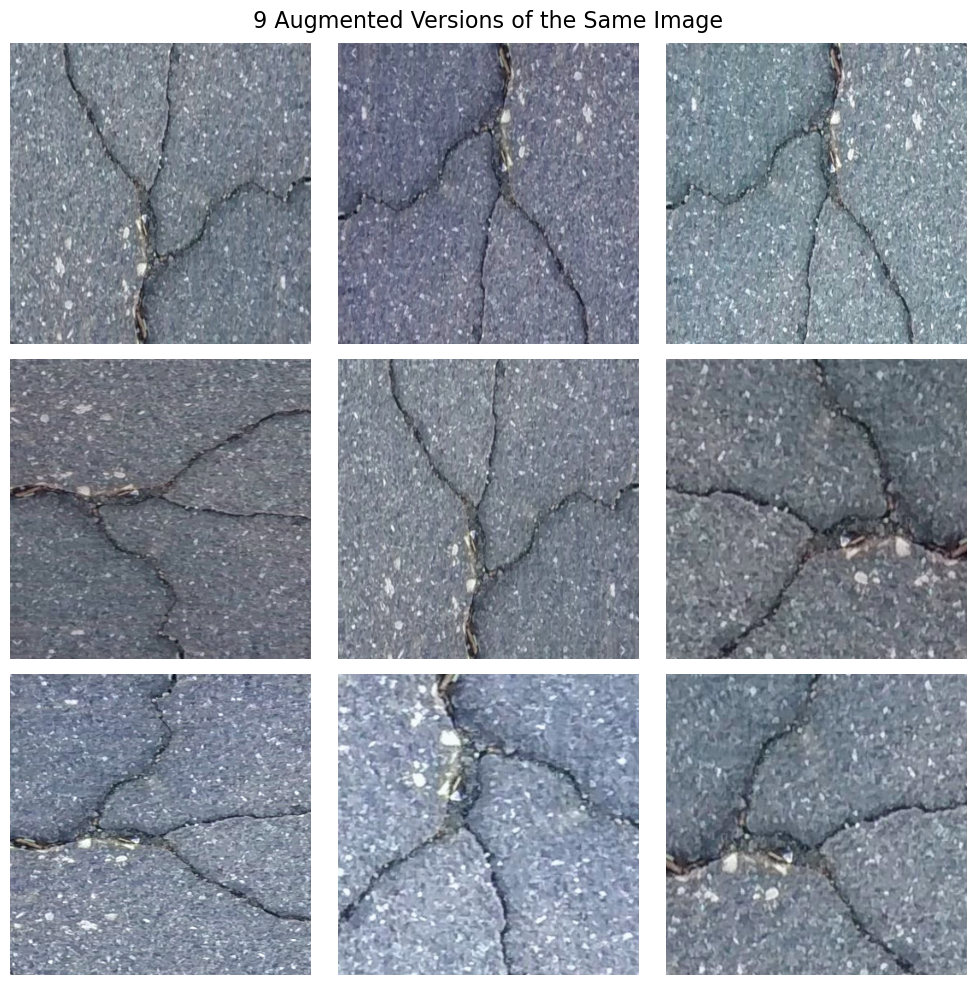

In [15]:
# Show 9 samples of augmentation on the same image

img_filename = '20160307_164226_1_1.jpg'
# Highres images (from train)
# img_filename =  'IMG_7968.JPG'

# set the file_addresses
img_addr = os.path.join('images', img_filename)

image = np.array(Image.open(img_addr))

plt.figure(figsize=(10, 10))
for i in range(9):
  # A.Compose takes an image and its mask (but we just want the img)
  augmented_images = train_transform(image=image, mask=image)
  augmented_image = augmented_images['image']
  ax = plt.subplot(3, 3, i + 1)
  ax.imshow(augmented_image)
  ax.set_xticks([])
  ax.set_yticks([])
  # plt.title(augmented_images.shape)
  ax.axis("off")
plt.suptitle(" 9 Augmented Versions of the Same Image ", fontsize=16)
plt.tight_layout()
# plt.savefig(f'outputs/Inferences/{train_timestamp}@inference_on_{img_filename}.png', bbox_inches='tight')
plt.show()

## Create and load Datasets (as PyTorch loader)

In [16]:
import utils.dataset
reload(utils.dataset)

# create our datasets (with our custom Class)
train_ds = SegmentaionDataset(
    image_dir=hyper_params['train_img_dir'],
    mask_dir=hyper_params['train_mask_dir'],
    transform=train_transform,
    preprocess_fn=preprocess_input,
    mask_suffix="",
    subset=[0, 10],
)
val_ds = SegmentaionDataset(
    image_dir=hyper_params['val_img_dir'],
    mask_dir=hyper_params['val_mask_dir'],
    transform=val_transform,
    preprocess_fn=preprocess_input,
    mask_suffix="",
    subset=[0, 5],
)
# test_ds = SegmentaionDataset(
#     image_dir=hyper_params['test_img_dir'],
#     mask_dir=hyper_params['test_mask_dir'],
#     transform=val_transform,
#     preprocess_fn=preprocess_input,
#     mask_suffix="",
#     # subset=[0, 5],
# )

# Create Datatset by data loaders
train_loader, val_loader = get_loaders(
    train_ds,
    val_ds,
    # test_ds,
    batch_size=hyper_params['batch_size'],
    num_workers=hyper_params['num_workers'],
    pin_memory=hyper_params['pin_mem'],
    worker_init_fn=seed_worker,
    generator=DATA_LOADER_GEN,
)

In [16]:
# (Fast) Using Dataset's __len__ magic method (always work)
print("# train images:", len(train_ds))
print("# val images:", len(val_ds))
# print("# test images:", len(test_ds))

# (Slow) Using Data Loader (is a hit or miss)
# print('# train images:', sum(len(batch) for batch in train_loader))
# print('# val images:', sum(len(batch) for batch in val_loader))

# this outputs wrong nume (why??)
# it's not even the #imgs in mini_batch??
# print(len(train_loader))

NameError: name 'train_ds' is not defined

## Visualize Dataset(s)


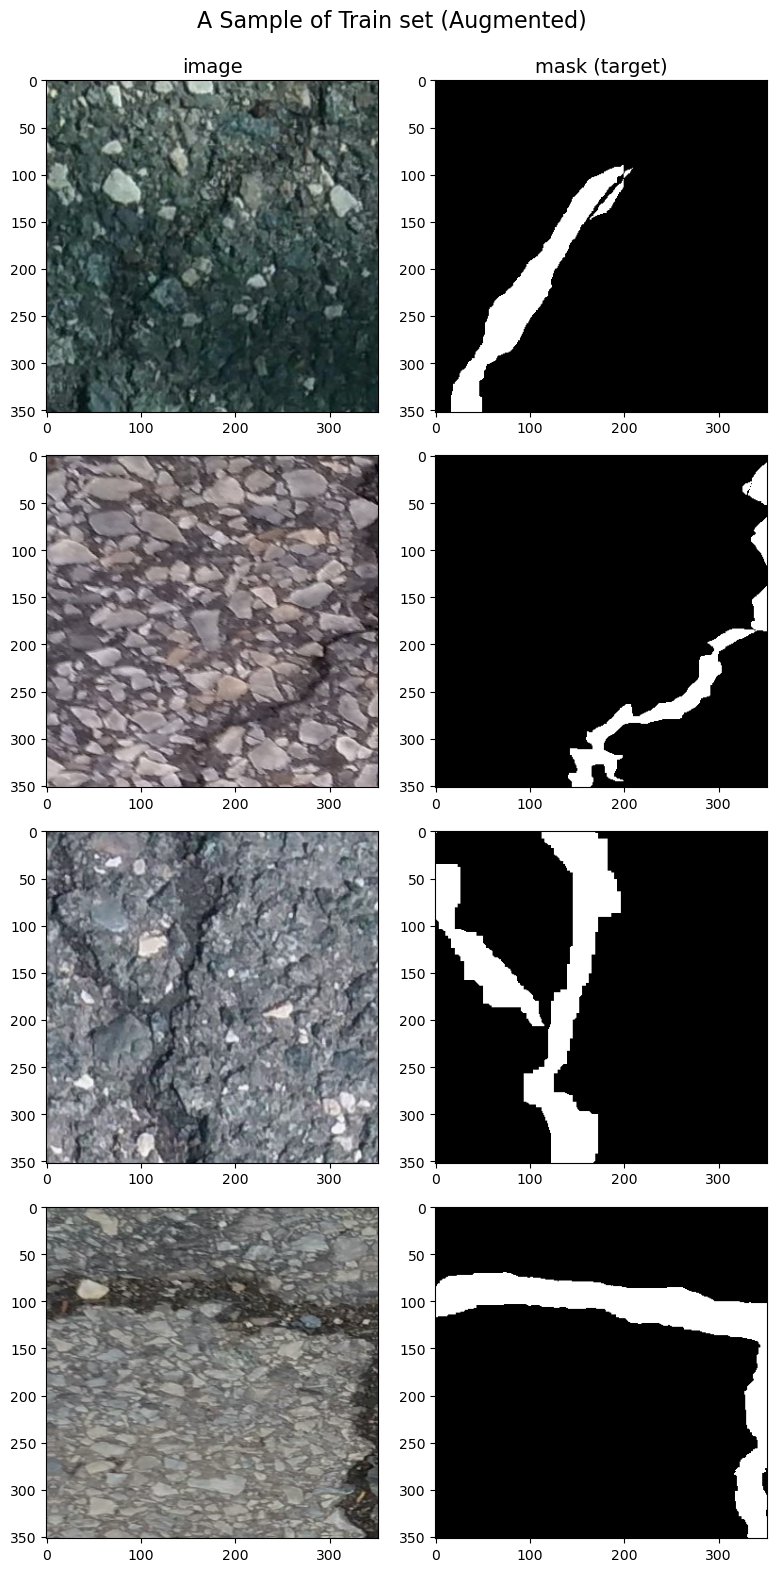

In [25]:

from utils import visualization
reload(visualization)

# Get a batch of data
# as the train_loader has shuffle=True
# the next batch of data is random (as opposed to val/test loaders)
train_batch = next(iter(train_loader))
img_batch = train_batch[0]
mask_batch = train_batch[1]

image_mask_plot(
    [img_batch, mask_batch],
    data_format="channels_first",
    num_rows=4,
    plot_axes=True,
    anti_standardize_fn=ImageAntiStandardize(IMAGENET_MEAN, IMAGENET_STD, [0, 1]),
)

plt.suptitle("A Sample of Train set (Augmented)\n", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Get a batch of data
num_batches = val_ds.pred_num_batches(hyper_params['batch_size'])

if num_batches > 1:
    batch_idx = random.randint(1, num_batches) - 1 # which mini_batch to get?
    train_batch = next(islice(val_loader, batch_idx - 1, batch_idx))
else:
    batch_idx = 0
    train_batch = next(iter(val_loader))

# split the batch to img, mask (each a 4D-Tensor)
img_batch = train_batch[0]
mask_batch = train_batch[1]

image_mask_plot(
    [img_batch, mask_batch],
    data_format="channels_first",
    num_rows=3,
    plot_axes=True,
    anti_standardize_fn=ImageAntiStandardize(IMAGENET_MEAN, IMAGENET_STD, [0, 1]),
)

plt.suptitle(f"A Sample from batch number {batch_idx+1}/{num_batches} of Val set (not Augmented)\n", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Get a batch of data
num_batches = test_ds.pred_num_batches(hyper_params['batch_size'])

if num_batches > 1:
    batch_idx = random.randint(1, num_batches) - 1 # which mini_batch to get?
    # test_batch = next(islice(iter(test_loader), batch_idx - 1, batch_idx))
    train_batch = next(islice(test_loader, batch_idx - 1, batch_idx))
else:
    batch_idx = 0
    train_batch = next(iter(test_loader))

# split the batch to img, mask (each a 4D-Tensor)
img_batch = train_batch[0]
mask_batch = train_batch[1]

image_mask_plot(
    [img_batch, mask_batch],
    data_format="channels_first",
    num_rows=3,
    plot_axes=True,
    anti_standardize_fn=ImageAntiStandardize(IMAGENET_MEAN, IMAGENET_STD, [0, 1]),
)

plt.suptitle(f"A Sample from batch number {batch_idx+1}/{num_batches} of Test set (not Augmented)\n", fontsize=16)
plt.tight_layout()
plt.show()

# Train


## Train with PyTorch Lightning
> Very high level and no control over things, whatsoever. I'm better off with my own custom train loop.

In [39]:
# import pytorch_lightning as pl

# class BinarySegmentModelLightning(pl.LightningModule):

#     def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
#         super().__init__()
#         self.model = smp.create_model(
#             arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
#         )

#         # preprocessing parameteres for image
#         params = smp.encoders.get_preprocessing_params(encoder_name)
#         self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
#         self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

#         # for image segmentation dice loss could be the best first choice
#         self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

#     def forward(self, image):
#         # normalize image here
#         # image = (image - self.mean) / self.std
#         mask = self.model(image).float()
#         return mask

#     def shared_step(self, batch, stage):
        
#         image = batch[0].float()

#         # Shape of the image should be (batch_size, num_channels, height, width)
#         # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
#         assert image.ndim == 4

#         # Check that image dimensions are divisible by 32, 
#         # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
#         # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
#         # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
#         # and we will get an error trying to concat these features
#         h, w = image.shape[2:]
#         assert h % 32 == 0 and w % 32 == 0

#         mask = batch[1].float()

#         # Shape of the mask should be [batch_size, num_classes, height, width]
#         # for binary segmentation num_classes = 1
#         assert mask.ndim == 4

#         # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
#         assert mask.max() <= 1.0 and mask.min() >= 0

#         logits_mask = self.forward(image)
        
#         # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
#         loss = self.loss_fn(logits_mask, mask)

#         # Lets compute metrics for some threshold
#         # first convert mask values to probabilities, then 
#         # apply thresholding
#         prob_mask = logits_mask.sigmoid()
#         pred_mask = (prob_mask > 0.5).float()

#         # We will compute IoU metric by two ways
#         #   1. dataset-wise
#         #   2. image-wise
#         # but for now we just compute true positive, false positive, false negative and
#         # true negative 'pixels' for each image and class
#         # these values will be aggregated in the end of an epoch
#         tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
#         # with float() on mask got error: Target should be one of the integer types
#         # tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.float(), mask.float(), mode="binary")

#         return {
#             "loss": loss,
#             "tp": tp,
#             "fp": fp,
#             "fn": fn,
#             "tn": tn,
#         }

#     def shared_epoch_end(self, outputs, stage):
#         # aggregate step metics
#         tp = torch.cat([x["tp"] for x in outputs])
#         fp = torch.cat([x["fp"] for x in outputs])
#         fn = torch.cat([x["fn"] for x in outputs])
#         tn = torch.cat([x["tn"] for x in outputs])

#         # per image IoU means that we first calculate IoU score for each image 
#         # and then compute mean over these scores
#         per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
#         # dataset IoU means that we aggregate intersection and union over whole dataset
#         # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
#         # in this particular case will not be much, however for dataset 
#         # with "empty" images (images without target class) a large gap could be observed. 
#         # Empty images influence a lot on per_image_iou and much less on dataset_iou.
#         dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

#         metrics = {
#             f"{stage}_per_image_iou": per_image_iou,
#             f"{stage}_dataset_iou": dataset_iou,
#         }
        
#         self.log_dict(metrics, prog_bar=True)

#     def training_step(self, batch, batch_idx):
#         return self.shared_step(batch, "train")            

#     # def training_epoch_end(self, outputs):
#     #     return self.shared_epoch_end(outputs, "train")
#     def on_train_epoch_end(self):
#         # return self.shared_epoch_end(outputs, "train")
#         pass

#     def validation_step(self, batch, batch_idx):
#         return self.shared_step(batch, "valid")

#     # def on_validation_epoch_end(self, outputs):
#     def on_validation_epoch_end(self):
#         # return self.shared_epoch_end(outputs, "valid")
#         # return self.shared_epoch_end(outputs, "valid")
#         pass

#     def test_step(self, batch, batch_idx):
#         return self.shared_step(batch, "test")  

#     def on_test_epoch_end(self):
#         # return self.shared_epoch_end(outputs, "test")
#         pass

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=0.0001)

In [40]:
# model = BinarySegmentModelLightning("UnetPlusPlus", hyper_params['pretrained_model_encoder'], in_channels=3, out_classes=1)

In [63]:
# trainer = pl.Trainer(
#     accelerator='gpu', 
#     max_epochs=1,
# )

# trainer.fit(
#     model, 
#     train_dataloaders=train_loader, 
#     val_dataloaders=val_loader,
# )

In [64]:
# from utils.training import evaluate_fn, predict_fn

# # go to inference mode
# model.eval()  # no need as this line exists in validation_fn
# model.to(device)

# history_test = evaluate_fn(
#     test_loader,
#     model,
#     loss_fn,
#     dict.fromkeys(metrics_list, 0),
#     metrics,
#     device,
# )

# df = pd.DataFrame(history_test, index=[0])
# # df.to_csv(f"outputs{os.sep}history{os.sep}{hyper_params['train_timestamp']}@history_evaluation_test.csv", index=False)
# print(" Metrics for Evaluation on Test Set ".center(79, " "))
# display(df)
# del df

## Define the Common Train Configs (for both Phase 1 & 2 of Transfer Learning)

In [17]:
from utils.training import fit_fn
import utils.training
import utils.metrics

reload(utils.training)
reload(utils.metrics)

# a dict to map metrics' name to correspoing fn
metrics = {
    "accuracy": AccuracyBinarySegment(from_logits=True),  # remove as its very misleading
    "jaccard (IOU)": JaccardBinarySegment(from_logits=True),  # my custom jaccard
    "recall": RecallBinarySegment(from_logits=True),
    "precision": PrecisionBinarySegment(from_logits=True),
    "dice (F1 Score)": DiceBinarySegment(from_logits=True),  # my custom dice
    # "f1 score": F1BinarySegment(from_logits=True),  # is redundant as is the same as Dice
}

metrics_list = ["loss"] + list(metrics)

# define the loss_fn
loss_fn = nn.BCEWithLogitsLoss()
# TODO: Create DICE+BCE loss func (as most papers use this)
loss_fn = DiceBCELoss(from_logits=True)

hyper_params['loss_fn'] = str(loss_fn)

from functools import partial
#TODO: create a fit_fn_partial to use in both phase 1 & 2

## Transfer Learning

### Phase 1: Freeze the Encoder

In [18]:
# freeze the entire encoder
for param in model.encoder.parameters():
    param.requires_grad = False

# Check if it was done correctly
# for param in model.parameters():
#     print(f'{param.requires_grad = }')

#### Train with my Cusom train_loop (Hard but more control)

In [ ]:
# get the date-time (for filenames)
# keep in the training cell block to make it accurately the same time as start of training
train_timestamp = datetime.today().strftime(time_format)
# add the generated timestamp to hyperparams, so can use it for evaluate/predict
hyper_params['train_timestamp'] = train_timestamp

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=hyper_params["lr"])
hyper_params['optimizer'] = [i.strip("(\s ") for i in str(optimizer).split('\n')][:-1]

# define the scheduler
# option 1: time-based schedule
# scheduler = StepLR(
#     optimizer,
#     step_size=hyper_params["lr_decay_step"],
#     gamma=hyper_params["lr_decary_factor"],
# )
# option 2: Decay based on loss
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=hyper_params["scheduler_factor"],
    patience=2,
    min_lr=1e-6,
    threshold=1e-3,  # only changes greater than threshold (e.g., 0.01) in val_<metric> is acceptable, otherwise decay lr_rate.
    verbose=True
)
#TODO: create a ReduceLROnPlateau_partial
hyper_params['scheduler'] = scheduler.state_dict()

# train the model
history = fit_fn(
    model,
    train_loader,
    optimizer,
    loss_fn,
    scheduler,
    metrics=metrics,
    val_loader=val_loader,
    epochs=hyper_params["epochs"],
    device=device,
    save_model=True,
    save_model_filename=f"models{os.sep}{train_timestamp}@model_checkpoint",
    save_model_temp=False,
    save_model_temp_filename=f"temp{os.sep}epoch_best_model_checkpoint{os.sep}temp_model_checkpoint",
)

# save hyperparams as a JSON file
hyper_params_export_name = (
    f"outputs{os.sep}hyperparams{os.sep}{train_timestamp}@hyperparams.json"
)
with open(hyper_params_export_name, "w") as f:
    json.dump(hyper_params, f)

# save the hyperparams to a csv file
# df_hyperparam = pd.DataFrame(hyper_params, index=[0]).T
# df_hyperparam.to_csv(f'outputs/hyperparams/{start_train_time}@hyperparams.csv', index=True, header=None)
# print('The HyperParameters'.ljust(79, " "))
# display(df_hyperparam)
# del df_hyperparam

In [ ]:
df = pd.DataFrame(history)
df.insert(loc=0, column="epoch", value=range(1, len(df.index) + 1))
df.to_csv(f"outputs/history/{train_timestamp}@history_training_train_val.csv", index=False)
print(" Metrics During Training ".center(79, " "))
display(df)
del df

In [ ]:
metrics_list = ["loss"] + list(metrics)

# allow seaborn to set the style only for this plot
with sns.axes_style("darkgrid", rc={"axes.grid": True}):
    plot_metrics(history, hyper_params["epochs"], metrics_list)
    plt.suptitle("Evaluation Metrics During Training (TL Phase 1)", fontsize=20)
    plt.tight_layout()
    plt.savefig(
        f"outputs/plots/{train_timestamp}@plot_training_metrics_train_val.pdf",
        bbox_inches="tight",
    )
    plt.show()

### Phase 2: Un-Freeze some later layers of Encoder to fine-tune it with out data
> Should we freeze the decoder, so that it doesn't get overfitted (as we have trained it in the phase 1?)
> lr_finetune & epochs_fine_tune for the phase 2

In [ ]:
# unfreeze a subset of encoder
# define the #layer (at the end) to unfreeze
num_encoder_layers = sum(1 for _ in model.encoder.parameters())
print(f'{num_encoder_layers = }')
encoder_cutoff_for_unfreeze = int(num_encoder_layers * 0.3)
print(f'{encoder_cutoff_for_unfreeze = }')
print(f'num_encoder_layers_to_unfreze = {num_encoder_layers - encoder_cutoff_for_unfreeze}')

# unfreeze only the later layers in the encoder
for layer_idx, param in enumerate(model.encoder.parameters()):
    if layer_idx+1 > encoder_cutoff_for_unfreeze:
        param.requires_grad = True

# (optional) freeze the entire decoder
#TODO: is it correct??? as the decoder will not adpat to the changed encoder
# maybe yes as the output layer is not freezed:
# note that the last two layers (the 1x1Conv + BN) are not in model.decoder.parameters() (ME)
# for param in model.decoder.parameters():
#     param.requires_grad = False

# Check if it was done correctly
# for param in model.parameters():
#     print(f'{param.requires_grad = }')

#### Train with my Cusom train_loop (Hard but more control)

In [ ]:
# define the optimizer (for phase 2)
# It's very important to load the parameters from phase 1
optimizer_finetune = optim.Adam(model.parameters(), lr=hyper_params["lr_finetune"])
hyper_params['optimizer_finetune'] = [i.strip("(\s ") for i in str(optimizer_finetune).split('\n')][:-1]

# define the scheduler (for phase 2)
scheduler_finetune = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=hyper_params["scheduler_factor_finetune"],
    patience=2,
    min_lr=1e-6,
    threshold=1e-6,  # only changes greater than threshold (e.g., 0.01) in val_<metric> is acceptable, otherwise decay lr_rate.
    verbose=True
)
hyper_params['scheduler_finetune'] = scheduler_finetune.state_dict()

# train the model
history_finetune = fit_fn(
    model,
    train_loader,
    optimizer,
    loss_fn,
    scheduler,
    metrics=metrics,
    val_loader=val_loader,
    epochs=hyper_params["epochs_finetune"],
    device=device,
    save_model=True,
    save_model_filename=f"models{os.sep}{train_timestamp}@model_checkpoint_finetune",
    save_model_temp=False,
    save_model_temp_filename=f"temp{os.sep}epoch_best_model_checkpoint{os.sep}temp_model_checkpoint",
)

In [ ]:
df = pd.DataFrame(history_finetune)
df.insert(loc=0, column="epoch", value=range(1, len(df.index) + 1))
df.to_csv(f"outputs/history/{train_timestamp}@history_training_train_val_finetune.csv", index=False)
print(" Metrics During Training ".center(79, " "))
display(df)
del df

In [ ]:
# allow seaborn to set the style only for this plot
with sns.axes_style("darkgrid", rc={"axes.grid": True}):
    plot_metrics_finetune(
        history,
        history_finetune,
        # metrics=list(metrics))
        metrics=metrics_list,
    )
    # metrics=['loss'])
    plt.suptitle("Evaluation Metrics During Training (TL Phase 1 + 2)", fontsize=20)
    plt.tight_layout()
    plt.savefig(
        f"outputs/plots/{train_timestamp}@plot_training_metrics_train_val_finetune.pdf",
        bbox_inches="tight",
    )
    plt.show()

# Inference

> for single images


NameError: name 'train_timestamp' is not defined

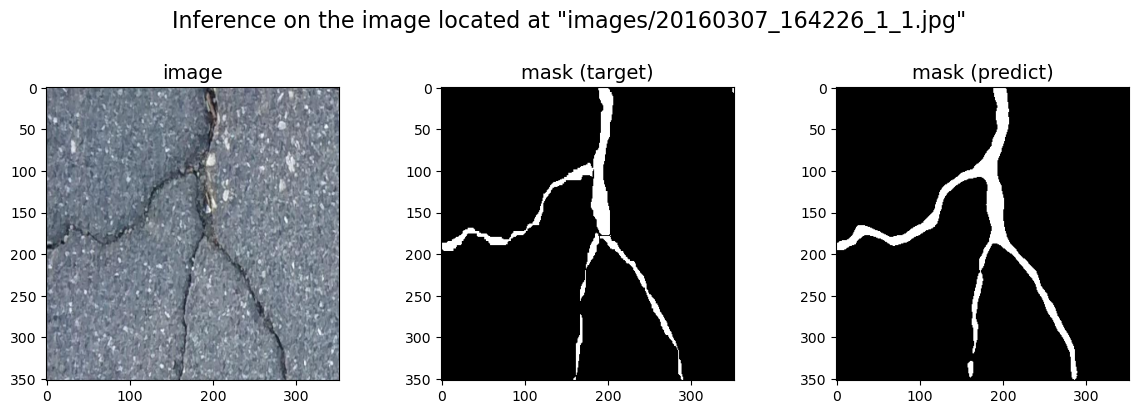

In [59]:
# Lowres images
# img 1 (from traincrop)
# img_filename =  '20160222_081011_1_721.jpg'
# mask_filename = '20160222_081011_1_721_mask.png'
# img 2 (from testcrop)
img_filename = '20160307_164226_1_1.jpg'
mask_filename = '20160307_164226_1_1_mask.png'
# Highres images (from train)
# img_filename =  '20160222_081102.jpg'
# mask_filename = '20160222_081102_mask.png'

# set the file_addresses
img_addr = os.path.join('images', img_filename)
mask_addr = os.path.join('images', mask_filename)

# ----------------------------------------------------
#TODO: make this section a func
# ----------------------------------------------------

# import the image, mask
img = np.array(Image.open(img_addr).convert("RGB"))
mask = np.array(Image.open(mask_addr).convert("L"), dtype=np.float32)

# apply the val_transformation (e.g., to resize)
# img, mask must be 3darray/2drray of shape (H, W, C)/(H, W)
augmentations = val_transform(image=img, mask=mask)
img_preprocess = augmentations.get("image")
mask_preprocess = augmentations.get("mask")

# Convert (H, W, C=3) to (N=1, H, W, C=3)
img_batch = np.expand_dims(img_preprocess, 0)
# convert (H, W) to (N=1, H, W, C=1)
mask_batch = np.expand_dims(mask_preprocess, [0, 3])

# return img_batch, mask_batch
# ----------------------------------------------------


# ----------------------------------------------------
#TODO: make this the a fn: ndarray (N, H, W, C) to torch.Tesnor (N, C, W, H)
# ----------------------------------------------------

# make the input tensor ready for model:
# 1. preprocess the input
img_batch_normal = preprocess_input(np.array(img_batch))
# 2. make it channels_first
img_tensor_normal_cfirst = img_batch_normal.transpose(0, 3, 1, 2)
# 3. Convert it to torch.Tensor
input = torch.Tensor(img_tensor_normal_cfirst)

# return input
# ----------------------------------------------------

# ----------------------------------------------------
#TODO: make this the .predict of model class
# ----------------------------------------------------

# send the model and the input to the device's MEM
input = input.to(device)
model.to(device)

# make inference to get a (N, C, H, W) torch.Tensor
yhat = model(input)

# return yaht
# ----------------------------------------------------


# ----------------------------------------------------
#TODO: make this a fn: make yhat binary
# can avoid converting to numpy and to it in torch
#TODO: can modify the utils/visualization/torch_tensor_for_plt instead of writing from scratch
# ----------------------------------------------------

# make the output numpy.ndarray + move it to cpu MEM
yhat = yhat.detach().cpu().numpy()
# make the pixel probabilites (i.e., [0, 1]) binary
thresh = 0.5
yhat_binary = np.where(yhat >= thresh, 1, 0)

# return yhat_binary
# ----------------------------------------------------

# convert (N=1, C=1, H, W) to (N=1, H, W, C=1)
# to compy with image_batch, mask_batch shapes
yhat_batch = yhat_binary.transpose(0, 2, 3, 1)

# return yaht_batch
# ----------------------------------------------------

# check the shapes before plot (to determine the data_format arg)
# print(f'{img_batch.shape = }')
# print(f'{mask_batch.shape = }')
# print(f'{yhat_batch.shape = }')

image_mask_plot(
    [img_batch, mask_batch, yhat_batch],
    data_format="channels_last",
    num_rows=1,
    plot_axes=True,
    anti_standardize_fn=None,
)

plt.suptitle(f'Inference on the image located at "{img_addr}"\n', fontsize=16)
plt.tight_layout()
plt.savefig(f'outputs/Inferences/{train_timestamp}@inference_on_{img_filename}.png', bbox_inches='tight')
plt.show()

In [ ]:
# # Lowres images
# # img 1 (from traincrop)
# # img_filename =  '20160222_081011_1_721.jpg'
# # mask_filename = '20160222_081011_1_721_mask.png'
# # img 2 (from testcrop)
# img_filename = '20160307_164226_1_1.jpg'
# mask_filename = '20160307_164226_1_1_mask.png'
# # Highres images (from train)
# # img_filename =  '20160222_081102.jpg'
# # mask_filename = '20160222_081102_mask.png'
# img_addr = os.path.join('images', img_filename)
# mask_addr = os.path.join('images', mask_filename)

# img = Image.open(img_addr).resize((hyper_params['image_width'], hyper_params['image_height']))
# mask = Image.open(mask_addr).resize((hyper_params['image_width'], hyper_params['image_height']))

# # normalize [-1, 1] the PIL image as a torch.Tensor
# img_tensor = (TF.functional.pil_to_tensor(img) / 127.5 - 1).to(device)

# model.to(device)
# yhat = model(img_tensor.unsqueeze(dim=0))
# yhat_c_last = yhat[0].moveaxis(0, -1).detach().cpu().numpy()
# thresh = 0.5
# mask_batch = np.where(yhat_c_last >= thresh, 255, 0)

# fig, axes = plt.subplots(1, 3, figsize=(30, 10))
# axes[0].imshow(img)
# axes[0].set_title(f'Image {img.size}', fontsize=16)
# axes[1].imshow(mask_batch, cmap='gray')
# axes[1].set_title(
#     f'Mask (predicted) {mask_batch.shape[:2][::-1]}', fontsize=16)
# axes[2].imshow(mask, cmap='gray')
# axes[2].set_title(f'Mask (target) {mask.size}', fontsize=16)
# plt.savefig(f'outputs/Inferences/{train_timestamp}@{img_filename}.png', bbox_inches='tight')
# plt.show()

In [ ]:
# from utils.visualization import torch_tensor_for_plt, plot_segmentation_inference
# from utils.inferencing import inference_segmentation, img_to_inference_tensor
# import utils.inferencing
# import utils.visualization
# reload(utils.inferencing)
# reload(utils.visualization)


# img_filename = '20160222_081011_1_721.jpg'
# mask_filename = '20160222_081011_1_721_mask.jpg'
# img_addr = os.path.join('images', img_filename)
# mask_addr = os.path.join('images', mask_filename)

# # only for one image, if multiple use utils.dataset
# test_img_batch = img_to_inference_tensor(
#     img_addr, size=(hyper_params['image_height'], hyper_params['image_width']))
# test_mask_batch = img_to_inference_tensor(
#     mask_addr, size=(hyper_params['image_height'], hyper_params['image_width']))

# # make an inference
# yhat_mask = inference_segmentation(
#     test_img_batch, model=model, normalize=True, device=device)

# # make torch.Tensors ready for pyplot
# test_img_batch = torch_tensor_for_plt(test_img_batch)
# test_mask_batch = torch_tensor_for_plt(test_mask_batch)
# yhat_mask = torch_tensor_for_plt(yhat_mask)

# # plot the inference
# plot_segmentation_inference(test_img_batch, test_mask_batch, yhat_mask)

#
